__1. Business Problem__

__1.1. Description__

- Source: https://www.kaggle.com/c/msk-redefining-cancer-treatment/
- Data: Memorial Sloan Kettering Cancer Center (MSKCC)
- Download training_variants.zip and training_text.zip from Kaggle.
- Context: https://www.kaggle.com/c/msk-redefining-cancer-treatment/discussion/35336#198462
- Problem statement: Classify the given genetic variations/mutations based on evidence from text-based clinical literature.

__1.2. Real-world/Business Objectives and Constraints__

- No low-latency requirement.
- Interpretability is important.
- Errors can be very costly.
- Probability of a data-point belonging to each class is needed.

__2. Machine Learning Problem Formulation__

__2.1. Data Overview__

- Source: https://www.kaggle.com/c/msk-redefining-cancer-treatment/data
- We have two data files: one conatins the information about the genetic mutations and the other contains the clinical evidence (text) that human experts/pathologists use to classify the genetic mutations.
- Both these data files are have a common column called ID
- Data file's information:
    - training_variants (ID, Gene, Variations, Class)
    - training_text (ID, Text)

__2.2. Mapping the Real-world Problem to a ML Problem__

__2.2.1. Type of Machine Learning Problem__

There are nine different classes a genetic mutation can be classified into --> multi class classification problem.

__2.2.2. Performance Metric__

- Source: https://www.kaggle.com/c/msk-redefining-cancer-treatment#evaluation
- Metric(s):
    - Multi class log-loss
    - Confusion matrix

__2.2.3. Machine Learing Objectives and Constraints__

- Objective: Predict the probability of each data-point belonging to each of the nine classes.
- Constraints:
    - Interpretability
    - Class probabilities are needed.
    - Penalize the errors in class probabilites --> metric is Log-loss.
    - No latency constraints.

__2.3. Train, CV and Test Datasets__

Split the dataset randomly into three parts train, cross validation and test with $64\%$, $16\%$, $20\%$ of data respectively.

__3. Exploratory Data Analysis__

Package

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from collections import Counter, defaultdict

In [3]:
from IPython.display import display

In [4]:
from matplotlib import pyplot as plt
from matplotlib import style
style.use(style='seaborn-deep')

In [5]:
from nltk.corpus import stopwords

In [6]:
from scipy import sparse

In [7]:
from tqdm import tqdm

In [8]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, confusion_matrix, log_loss, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import normalize

In [9]:
import math

In [10]:
import numpy as np

In [11]:
import pandas as pd

In [12]:
import re

In [13]:
import seaborn as sns

Data Reading

In [14]:
data_gv = pd.read_csv(filepath_or_buffer='training/training_variants')
display(data_gv.head())

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [15]:
data_t = pd.read_csv(filepath_or_buffer='training/training_text',
                     sep='\|\|',
                     engine='python',
                     names=['ID', 'TEXT'],
                     skiprows=1)
display(data_t.head())

,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


In [16]:
print(data_gv.shape)
print(data_t.shape)

(3321, 4)
(3321, 2)


In [17]:
def class_distribution(data, label, title='Data'):
    """
    This function plots the distribution of given data[label].
    """
    class_val_counts = data[label].value_counts().to_frame()
    percents = class_val_counts.apply(lambda x: round((x / data.shape[0]) * 100, 2))
    class_val_counts['Percentage'] = percents
    display(class_val_counts)
    
    plt.figure(figsize=(12, 6))
    bars = sns.barplot(x=class_val_counts.index, y=class_val_counts[label])
    for bar in bars.patches:
        bars.annotate(text=format(bar.get_height()),
                      xy=((bar.get_x() + bar.get_width() / 2), bar.get_height()),
                      ha='center',
                      va='center',
                      size=10,
                      xytext=(0, 6),
                      textcoords='offset points')
    plt.xlabel(xlabel=label)
    plt.ylabel(ylabel='Value Counts')
    plt.title(label=title)
    plt.show()

,Class,Percentage
7,953,28.70
4,686,20.66
1,568,17.10
2,452,13.61
6,275,8.28
5,242,7.29
3,89,2.68
9,37,1.11
8,19,0.57


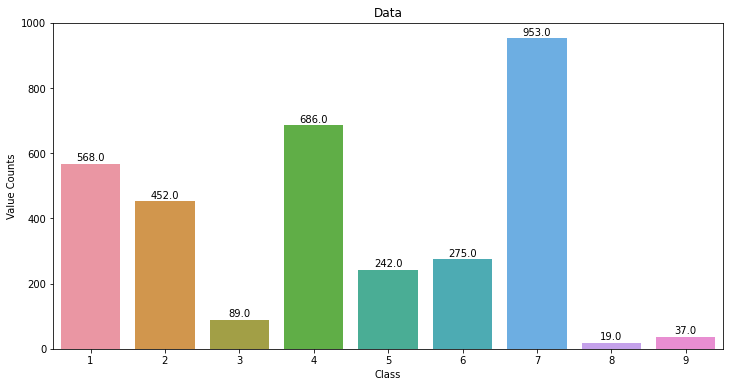

In [18]:
class_distribution(data=data_gv, label='Class')

In [19]:
display(data_gv.isnull().sum())

ID           0
Gene         0
Variation    0
Class        0
dtype: int64

In [20]:
display(data_t.isnull().sum())

ID      0
TEXT    5
dtype: int64

In [21]:
nan_indices = np.where(data_t['TEXT'].isnull())[0]
print(nan_indices)

[1109 1277 1407 1639 2755]


Basic Text Processing

In [22]:
stop_words = set(stopwords.words('english'))

In [23]:
def is_not_stopword(word):
    """
    This function returns `True` if the word is a stopword else `False`.
    """
    return word not in stop_words

In [24]:
def process_text(document):
    """
    This function processes the given document.
        1. Replace special char with a space.
        2. Replace multiple spaces with a single space.
        3. Convert the text into lower.
        4. Split the document string by space.
        5. Filter the words only if they are not in stopwords.
        6. Join the list as string.
    """
    if isinstance(document, str):
        document = re.sub(pattern='[^a-zA-Z0-9\n]', repl=' ', string=document)
        document = re.sub(pattern='\s+', repl=' ', string=document)
        document = document.lower()
        doc_words = document.split()
        doc_filtered_words = list(filter(is_not_stopword, doc_words))
        document = ' '.join(doc_filtered_words)
        return document

In [25]:
documents = list(map(process_text, tqdm(data_t['TEXT'].to_list())))

100%|██████████████████████████████████████████████| 3321/3321 [00:15<00:00, 209.34it/s]


In [26]:
data_t['TEXT'] = documents

In [27]:
display(data_t.head())

,ID,TEXT
0,0,cyclin dependent kinases cdks regulate variety...
1,1,abstract background non small cell lung cancer...
2,2,abstract background non small cell lung cancer...
3,3,recent evidence demonstrated acquired uniparen...
4,4,oncogenic mutations monomeric casitas b lineag...


Merge Datasets

In [28]:
results_df = pd.merge(left=data_gv, right=data_t, on='ID', how='left')
display(results_df.head())

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


Replace `NaN` TEXT with Gene and Variation

In [29]:
display(results_df.loc[results_df['TEXT'].isnull()])

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,None
1277,1277,ARID5B,Truncating Mutations,1,None
1407,1407,FGFR3,K508M,6,None
1639,1639,FLT1,Amplification,6,None
2755,2755,BRAF,G596C,7,None


In [30]:
results_df.loc[results_df['TEXT'].isnull(), 'TEXT'] = results_df['Gene'] + ' ' + results_df['Variation']
display(results_df.iloc[nan_indices])

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,FANCA S1088F
1277,1277,ARID5B,Truncating Mutations,1,ARID5B Truncating Mutations
1407,1407,FGFR3,K508M,6,FGFR3 K508M
1639,1639,FLT1,Amplification,6,FLT1 Amplification
2755,2755,BRAF,G596C,7,BRAF G596C


Features and Target

In [31]:
y = results_df['Class'].values
results_df['Gene'] = results_df['Gene'].str.replace('\s+', '_')
results_df['Variation'] = results_df['Variation'].str.replace('\s+', '_')

In [32]:
display(results_df.head())

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating_Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


In [33]:
train_df, test_df, y_train, y_test = train_test_split(results_df, y, stratify=y, test_size=0.2)
train_df, cv_df, y_train, y_cv = train_test_split(train_df, y_train, stratify=y_train, test_size=0.2)

,Class,Percentage
7,609,28.67
4,439,20.67
1,363,17.09
2,289,13.61
6,176,8.29
5,155,7.30
3,57,2.68
9,24,1.13
8,12,0.56


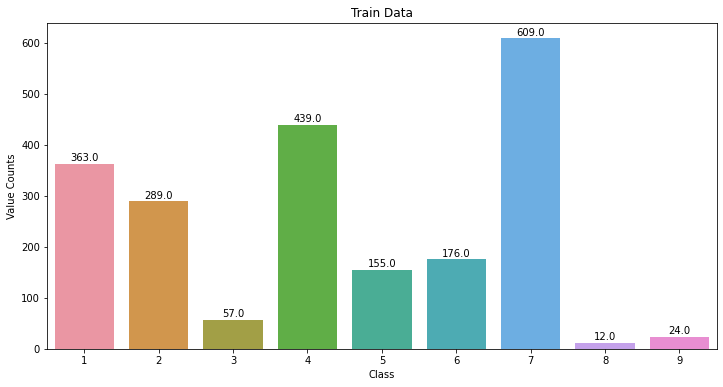

In [34]:
class_distribution(data=train_df, label='Class', title='Train Data')

,Class,Percentage
7,153,28.76
4,110,20.68
1,91,17.11
2,72,13.53
6,44,8.27
5,39,7.33
3,14,2.63
9,6,1.13
8,3,0.56


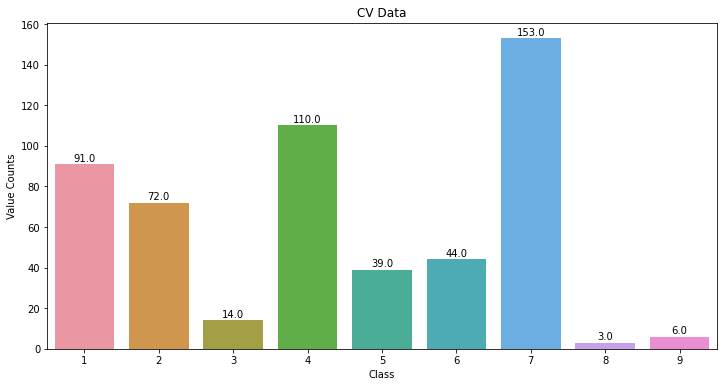

In [35]:
class_distribution(data=cv_df, label='Class', title='CV Data')

,Class,Percentage
7,191,28.72
4,137,20.60
1,114,17.14
2,91,13.68
6,55,8.27
5,48,7.22
3,18,2.71
9,7,1.05
8,4,0.60


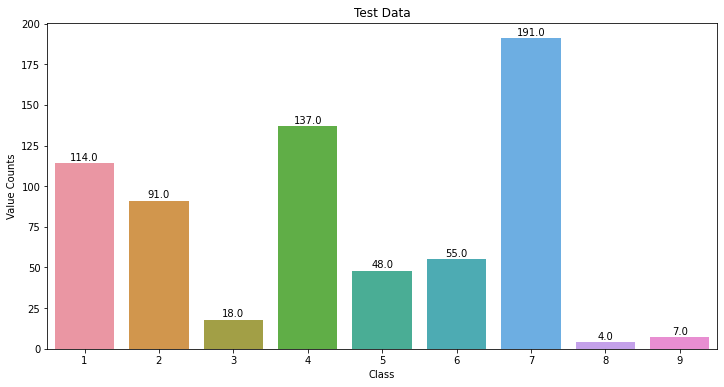

In [36]:
class_distribution(data=test_df, label='Class', title='Test Data')

Confusion Matrix

In [37]:
labels = data_gv.Class.unique()
print(labels)

[1 2 3 4 5 6 7 8 9]


In [38]:
cmat = np.array([[1, 2], [3, 4]])
cmatrix = np.matrix(data=cmat)
print(cmatrix)

[[1 2]
 [3 4]]


Precision Matrix Example

In [39]:
print(cmatrix)
print(cmatrix.sum(axis=0))
pmat = cmatrix / cmatrix.sum(axis=0)
print(pmat)
print(pmat.sum(axis=0))

[[1 2]
 [3 4]]
[[4 6]]
[[0.25       0.33333333]
 [0.75       0.66666667]]
[[1. 1.]]


Recall Matrix Example

In [40]:
print(cmatrix)
print(cmatrix.sum(axis=1))
rmat = cmatrix / cmatrix.sum(axis=1)
print(rmat)
print(rmat.sum(axis=1))

print()
print(cmatrix)
print(cmatrix.T)
print(cmatrix.sum(axis=1))
print(cmatrix.T / cmatrix.sum(axis=1).T)
rmat = ((cmatrix.T) / (cmatrix.sum(axis=1).T)).T
print(rmat)
print(rmat.sum(axis=1))

[[1 2]
 [3 4]]
[[3]
 [7]]
[[0.33333333 0.66666667]
 [0.42857143 0.57142857]]
[[1.]
 [1.]]

[[1 2]
 [3 4]]
[[1 3]
 [2 4]]
[[3]
 [7]]
[[0.33333333 0.42857143]
 [0.66666667 0.57142857]]
[[0.33333333 0.66666667]
 [0.42857143 0.57142857]]
[[1.]
 [1.]]


In [41]:
def plot_heatmap(matrix, title, labels):
    """
    This function plots the heatmap.
    """
    plt.figure(figsize=(14, 7))
    sns.heatmap(data=matrix,
                annot=True,
                fmt='.2f',
                linewidths=0.1,
                xticklabels=labels,
                yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Actual Class')
    plt.title(label=title)
    plt.show()

In [42]:
def plot_confusion_matrix(y_true, y_pred, labels):
    """
    This function plots:
        1. Confusion matrix
        2. Precision matrix
        3. Recall matrix
    """
    cmat = confusion_matrix(y_true=y_true, y_pred=y_pred)
    pmat = cmat / cmat.sum(axis=0)
    print("Column sum of precision matrix: {}".format(pmat.sum(axis=0)))
    rmat = ((cmat.T)/(cmat.sum(axis=1).T)).T
    print("Row sum of recall matrix:       {}".format(rmat.sum(axis=1)))
    
    plot_heatmap(matrix=cmat, title='Confusion Matrix', labels=labels)
    plot_heatmap(matrix=pmat, title='Precision Matrix', labels=labels)
    plot_heatmap(matrix=rmat, title='Recall Matrix', labels=labels)

Random Model

In [43]:
def build_random_model(train_df, cv_df, test_df, labels):
    """
    This function builds the random model.
    """
    y_train = train_df['Class'].values
    X_train = train_df.drop(columns=['Class'])
    
    y_cv = cv_df['Class'].values
    X_cv = cv_df.drop(columns=['Class'])
    
    y_test = test_df['Class'].values
    X_test = test_df.drop(columns=['Class'])
    
    dummy_clf = DummyClassifier(strategy='uniform')
    dummy_clf.fit(X=X_train, y=y_train)
    
    prob_pred_train = dummy_clf.predict_proba(X=X_train)
    train_log_loss = log_loss(y_true=y_train, y_pred=prob_pred_train, eps=1e-15)
    pred_train = dummy_clf.predict(X=X_train)
    
    prob_pred_cv = dummy_clf.predict_proba(X=X_cv)
    cv_log_loss = log_loss(y_true=y_cv, y_pred=prob_pred_cv, eps=1e-15)
    pred_cv = dummy_clf.predict(X=X_cv)
    
    prob_pred_test = dummy_clf.predict_proba(X=X_test)
    test_log_loss = log_loss(y_true=y_test, y_pred=prob_pred_test, eps=1e-15)
    pred_test = dummy_clf.predict(X=X_test)
    
    print("Train")
    print("Log Loss (Train): {}".format(train_log_loss))
    plot_confusion_matrix(y_true=y_train, y_pred=pred_train, labels=labels)
    print(classification_report(y_true=y_train, y_pred=pred_train))
    
    print("\nCross Validation")
    print("Log Loss (CV): {}".format(cv_log_loss))
    plot_confusion_matrix(y_true=y_cv, y_pred=pred_cv, labels=labels)
    print(classification_report(y_true=y_cv, y_pred=pred_cv))
    
    print("\nTest")
    print("Log Loss (Test): {}".format(test_log_loss))
    plot_confusion_matrix(y_true=y_test, y_pred=pred_test, labels=labels)
    print(classification_report(y_true=y_test, y_pred=pred_test))
    
    return pred_train, pred_cv, pred_test

Train
Log Loss (Train): 2.1972245773362196
Column sum of precision matrix: [1. 1. 1. 1. 1. 1. 1. 1. 1.]
Row sum of recall matrix:       [1. 1. 1. 1. 1. 1. 1. 1. 1.]


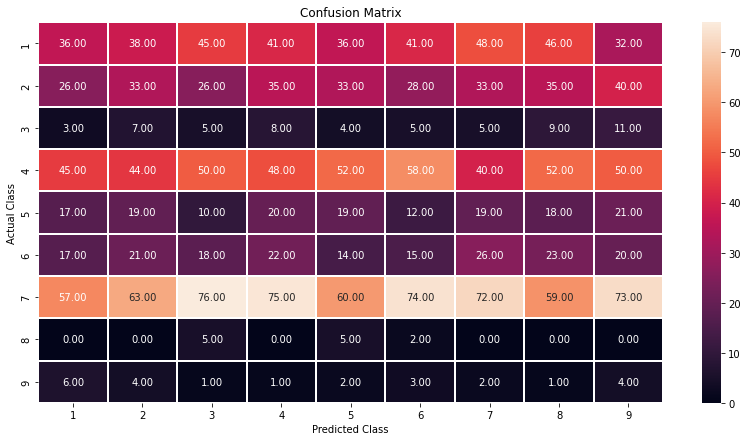

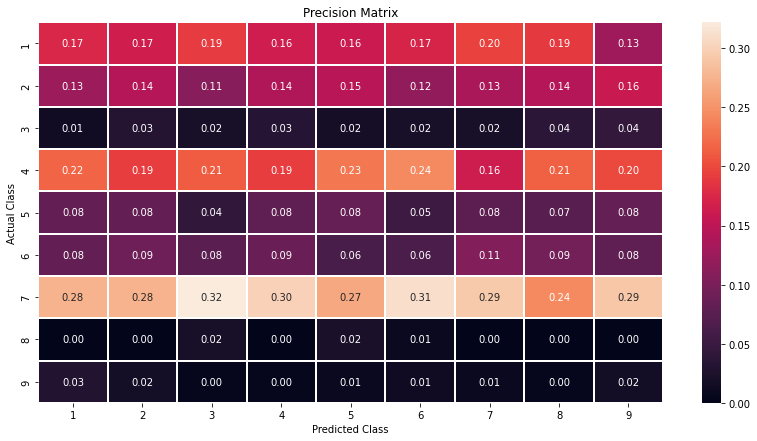

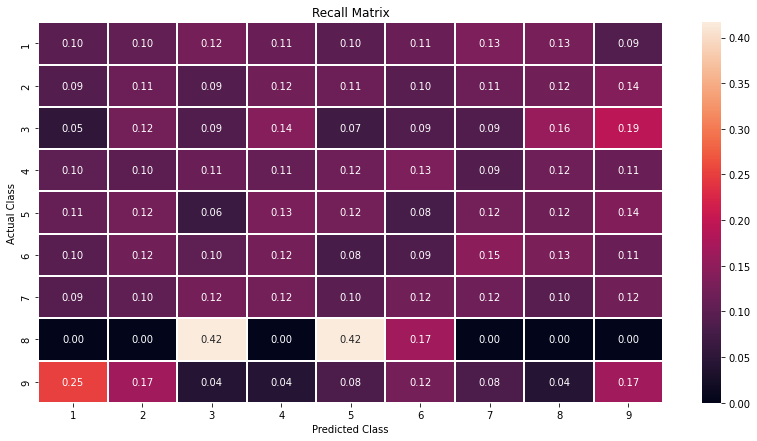

              precision    recall  f1-score   support

           1       0.17      0.10      0.13       363
           2       0.14      0.11      0.13       289
           3       0.02      0.09      0.03        57
           4       0.19      0.11      0.14       439
           5       0.08      0.12      0.10       155
           6       0.06      0.09      0.07       176
           7       0.29      0.12      0.17       609
           8       0.00      0.00      0.00        12
           9       0.02      0.17      0.03        24

    accuracy                           0.11      2124
   macro avg       0.11      0.10      0.09      2124
weighted avg       0.19      0.11      0.13      2124


Cross Validation
Log Loss (CV): 2.1972245773362196
Column sum of precision matrix: [1. 1. 1. 1. 1. 1. 1. 1. 1.]
Row sum of recall matrix:       [1. 1. 1. 1. 1. 1. 1. 1. 1.]


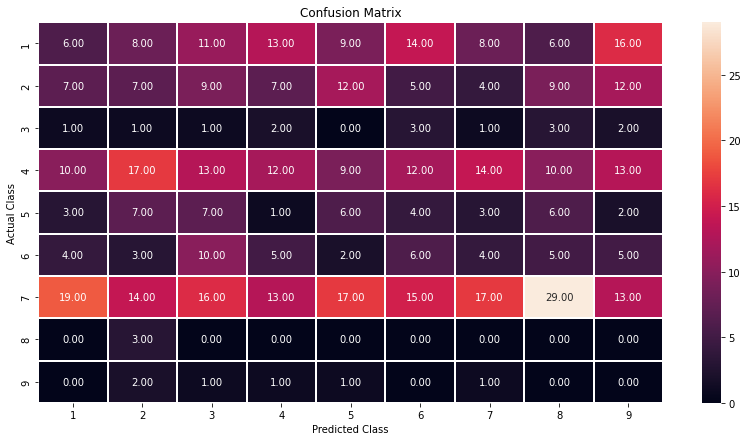

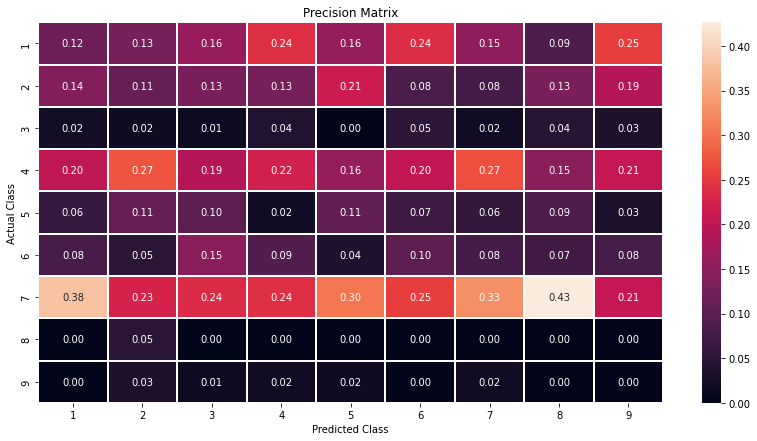

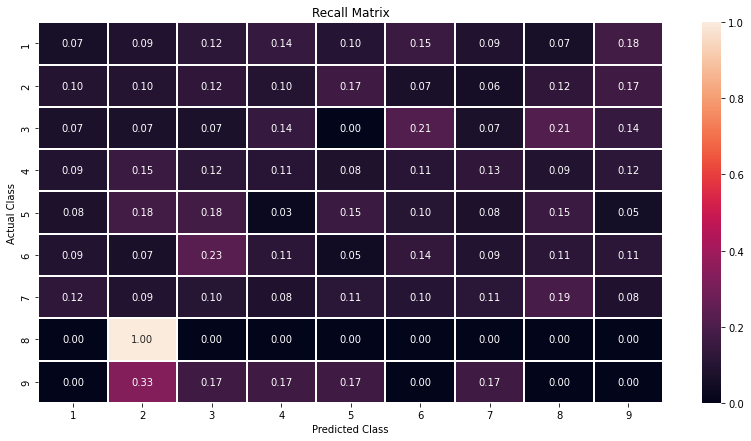

              precision    recall  f1-score   support

           1       0.12      0.07      0.09        91
           2       0.11      0.10      0.10        72
           3       0.01      0.07      0.02        14
           4       0.22      0.11      0.15       110
           5       0.11      0.15      0.13        39
           6       0.10      0.14      0.12        44
           7       0.33      0.11      0.17       153
           8       0.00      0.00      0.00         3
           9       0.00      0.00      0.00         6

    accuracy                           0.10       532
   macro avg       0.11      0.08      0.09       532
weighted avg       0.19      0.10      0.13       532


Test
Log Loss (Test): 2.1972245773362196
Column sum of precision matrix: [1. 1. 1. 1. 1. 1. 1. 1. 1.]
Row sum of recall matrix:       [1. 1. 1. 1. 1. 1. 1. 1. 1.]


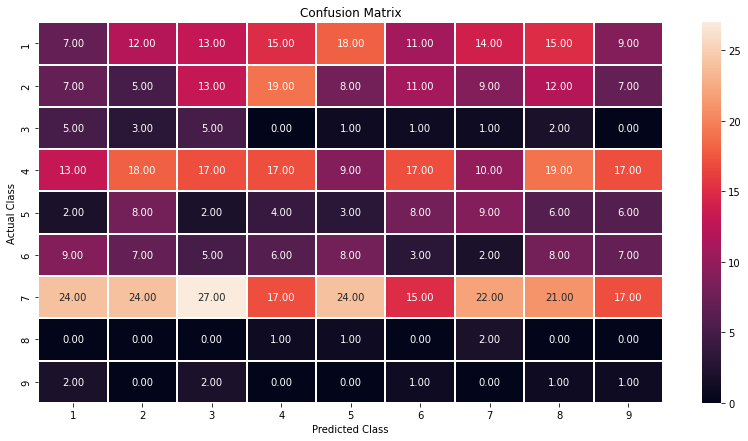

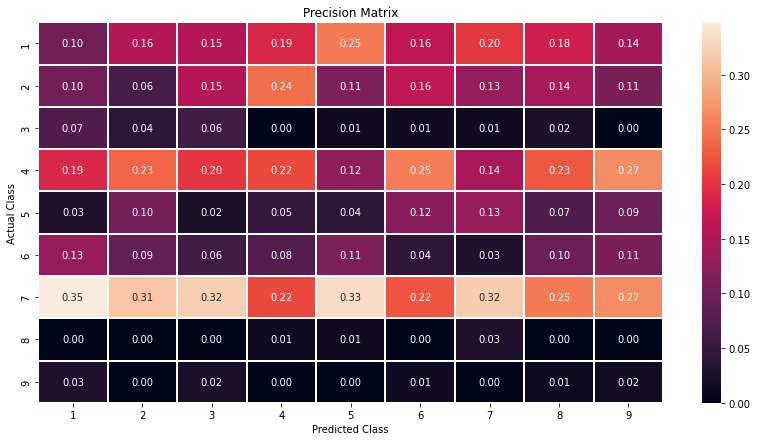

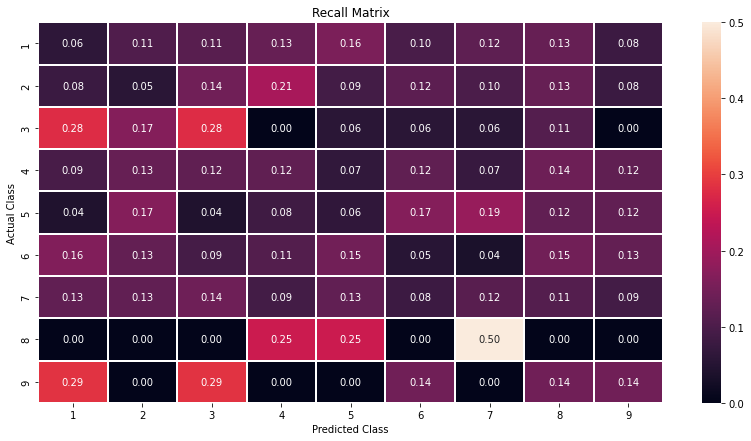

              precision    recall  f1-score   support

           1       0.10      0.06      0.08       114
           2       0.06      0.05      0.06        91
           3       0.06      0.28      0.10        18
           4       0.22      0.12      0.16       137
           5       0.04      0.06      0.05        48
           6       0.04      0.05      0.05        55
           7       0.32      0.12      0.17       191
           8       0.00      0.00      0.00         4
           9       0.02      0.14      0.03         7

    accuracy                           0.09       665
   macro avg       0.10      0.10      0.08       665
weighted avg       0.17      0.09      0.11       665



In [44]:
train_preds, cv_preds, test_preds = build_random_model(train_df=train_df,
                                                       cv_df=cv_df,
                                                       test_df=test_df,
                                                       labels=labels)

Response Coding - Class

In [45]:
class ResponseCoding(object):
    """
    This class is responsible for response coding.
    """
    
    def __init__(self, train_df, cv_df, test_df, df_cols, t_col, alpha=1, factor=10):
        self.train_df = train_df
        self.cv_df = cv_df
        self.test_df = test_df
        self.df_cols = df_cols
        self.t_col = t_col
        self.unique_targets = pd.unique(values=self.train_df[self.t_col])
        self.alpha = alpha
        self.factor = factor
        self.k = len(self.unique_targets)
    
    def perform_response_coding_on_column(self, col, df, laplace=False):
        """
        This method performs response coding on a given column and dataframe.
        """
        col_df = pd.DataFrame()
        total_dict = self.train_df[col].value_counts().to_dict()
        t_col_wise_dict = self.train_df[[col, self.t_col]].value_counts().to_dict()
        if df == 'test':
            df = self.test_df
        elif df == 'cv':
            df = self.cv_df
        else:
            df = self.train_df
        for t_val in self.unique_targets:
            t_list = list()
            for c_val in df[col]:
                try:
                    if c_val not in total_dict.keys():
                        if laplace:
                            add_val = self.alpha * self.factor
                            n_val = (1 + add_val)
                            d_val = self.k + (add_val * self.k)
                            f_val = n_val / d_val
                        else:
                            f_val = 1 / self.k
                        t_list.append(f_val)
                    else:
                        if laplace:
                            add_val = self.alpha * self.factor
                            n_val = t_col_wise_dict[(c_val, t_val)] + add_val
                            d_val = total_dict[c_val] + (add_val * self.k)
                            f_val = n_val / d_val
                        else:
                            f_val = t_col_wise_dict[(c_val, t_val)] / total_dict[c_val]
                        t_list.append(f_val)
                except KeyError as ke:
                    t_list.append(0)
            col_df[col+'_'+str(t_val)] = t_list
        return col_df
    
    def perform_response_coding(self, df, laplace):
        """
        This method performs response coding for an entire dataframe.
        """
        dfs = list()
        for col in self.df_cols:
            col_df = self.perform_response_coding_on_column(col=col, df=df, laplace=laplace)
            dfs.append(col_df)
        rc_df = pd.concat(dfs, axis=1)
        return rc_df

In [46]:
rc = ResponseCoding(train_df=train_df, test_df=test_df, cv_df=cv_df, df_cols=['Gene'], t_col='Class')
print("Encoded train data.")
display(rc.perform_response_coding(df='train', laplace=False).head())
print("Encoded cv data.")
display(rc.perform_response_coding(df='cv', laplace=False).head())
print("Encoded test data.")
display(rc.perform_response_coding(df='test', laplace=False).head())

Encoded train data.


,Gene_7,Gene_2,Gene_4,Gene_1,Gene_5,Gene_6,Gene_3,Gene_9,Gene_8
0,0.833333,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
1,0.666667,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
2,0.000000,0.000000,0.939759,0.000000,0.012048,0.000000,0.048193,0.0,0.0
3,0.000000,0.000000,0.642857,0.321429,0.000000,0.035714,0.000000,0.0,0.0
4,0.781250,0.062500,0.000000,0.000000,0.000000,0.000000,0.156250,0.0,0.0


Encoded cv data.


,Gene_7,Gene_2,Gene_4,Gene_1,Gene_5,Gene_6,Gene_3,Gene_9,Gene_8
0,0.740741,0.037037,0.000000,0.000000,0.037037,0.148148,0.037037,0.0,0.0
1,0.000000,0.000000,0.025974,0.103896,0.168831,0.701299,0.000000,0.0,0.0
2,0.000000,0.000000,0.153846,0.237179,0.397436,0.185897,0.025641,0.0,0.0
3,0.640000,0.160000,0.040000,0.000000,0.120000,0.040000,0.000000,0.0,0.0
4,0.500000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.0,0.0


Encoded test data.


,Gene_7,Gene_2,Gene_4,Gene_1,Gene_5,Gene_6,Gene_3,Gene_9,Gene_8
0,0.0,0.0,0.875000,0.000000,0.125000,0.000000,0.0,0.0,0.0
1,0.0,0.0,0.555556,0.444444,0.000000,0.000000,0.0,0.0,0.0
2,0.0,0.0,0.025974,0.103896,0.168831,0.701299,0.0,0.0,0.0
3,0.0,0.0,0.555556,0.444444,0.000000,0.000000,0.0,0.0,0.0
4,0.0,0.0,0.025974,0.103896,0.168831,0.701299,0.0,0.0,0.0


In [47]:
rc = ResponseCoding(train_df=train_df, test_df=test_df, cv_df=cv_df, df_cols=['Gene'], t_col='Class')
print("Encoded train data.")
display(rc.perform_response_coding(df='train', laplace=True).head())
print("Encoded cv data.")
display(rc.perform_response_coding(df='cv', laplace=True).head())
print("Encoded test data.")
display(rc.perform_response_coding(df='test', laplace=True).head())

Encoded train data.


,Gene_7,Gene_2,Gene_4,Gene_1,Gene_5,Gene_6,Gene_3,Gene_9,Gene_8
0,0.156250,0.114583,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.0
1,0.129032,0.118280,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.0
2,0.000000,0.000000,0.508671,0.000000,0.063584,0.00000,0.080925,0.0,0.0
3,0.000000,0.000000,0.237288,0.161017,0.000000,0.09322,0.000000,0.0,0.0
4,0.286885,0.098361,0.000000,0.000000,0.000000,0.00000,0.122951,0.0,0.0


Encoded cv data.


,Gene_7,Gene_2,Gene_4,Gene_1,Gene_5,Gene_6,Gene_3,Gene_9,Gene_8
0,0.256410,0.094017,0.000000,0.000000,0.094017,0.119658,0.094017,0.0,0.0
1,0.000000,0.000000,0.071856,0.107784,0.137725,0.383234,0.000000,0.0,0.0
2,0.000000,0.000000,0.138211,0.191057,0.292683,0.158537,0.056911,0.0,0.0
3,0.226087,0.121739,0.095652,0.000000,0.113043,0.095652,0.000000,0.0,0.0
4,0.119565,0.000000,0.119565,0.000000,0.000000,0.000000,0.000000,0.0,0.0


Encoded test data.


,Gene_7,Gene_2,Gene_4,Gene_1,Gene_5,Gene_6,Gene_3,Gene_9,Gene_8
0,0.0,0.0,0.173469,0.000000,0.112245,0.000000,0.0,0.0,0.0
1,0.0,0.0,0.151515,0.141414,0.000000,0.000000,0.0,0.0,0.0
2,0.0,0.0,0.071856,0.107784,0.137725,0.383234,0.0,0.0,0.0
3,0.0,0.0,0.151515,0.141414,0.000000,0.000000,0.0,0.0,0.0
4,0.0,0.0,0.071856,0.107784,0.137725,0.383234,0.0,0.0,0.0


In [48]:
rc = ResponseCoding(train_df=train_df, test_df=test_df, cv_df=cv_df, df_cols=['Variation'], t_col='Class')
print("Encoded train data.")
display(rc.perform_response_coding(df='train', laplace=False).head())
print("Encoded cv data.")
display(rc.perform_response_coding(df='cv', laplace=False).head())
print("Encoded test data.")
display(rc.perform_response_coding(df='test', laplace=False).head())

Encoded train data.


,Variation_7,Variation_2,Variation_4,Variation_1,Variation_5,Variation_6,Variation_3,Variation_9,Variation_8
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Encoded cv data.


,Variation_7,Variation_2,Variation_4,Variation_1,Variation_5,Variation_6,Variation_3,Variation_9,Variation_8
0,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111
1,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111
2,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111
3,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111
4,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111


Encoded test data.


,Variation_7,Variation_2,Variation_4,Variation_1,Variation_5,Variation_6,Variation_3,Variation_9,Variation_8
0,0.000000,0.000000,0.170213,0.808511,0.000000,0.021277,0.000000,0.000000,0.000000
1,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111
2,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111
3,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111
4,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111


In [49]:
rc = ResponseCoding(train_df=train_df, test_df=test_df, cv_df=cv_df, df_cols=['Variation'], t_col='Class')
print("Encoded train data.")
display(rc.perform_response_coding(df='train', laplace=True).head())
print("Encoded cv data.")
display(rc.perform_response_coding(df='cv', laplace=True).head())
print("Encoded test data.")
display(rc.perform_response_coding(df='test', laplace=True).head())

Encoded train data.


,Variation_7,Variation_2,Variation_4,Variation_1,Variation_5,Variation_6,Variation_3,Variation_9,Variation_8
0,0.130435,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.120879,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.000000,0.120879,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.000000,0.120879,0.0,0.0,0.0,0.0,0.0,0.0
4,0.120879,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


Encoded cv data.


,Variation_7,Variation_2,Variation_4,Variation_1,Variation_5,Variation_6,Variation_3,Variation_9,Variation_8
0,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111
1,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111
2,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111
3,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111
4,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111


Encoded test data.


,Variation_7,Variation_2,Variation_4,Variation_1,Variation_5,Variation_6,Variation_3,Variation_9,Variation_8
0,0.000000,0.000000,0.131387,0.350365,0.000000,0.080292,0.000000,0.000000,0.000000
1,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111
2,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111
3,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111
4,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111


Univariate Analysis on Gene Feature

Questions

1. Gene, what type of feature is it?
2. How many categories are there? How are they distributed?
3. How to featurize the Gene feature?
4. How good is this Gene feaure in predicting the Class label?
5. Is Gene feature stable across the data sets (Train, Test, and Validation)?

1. Gene, what type of feature is it?
    - Gene feature is categorical feature.

2. How many categories are there? How are they distributed?

In [50]:
unique_genes = train_df['Gene'].value_counts().to_frame()
print(unique_genes.shape)
display(unique_genes.head(n=10))

(240, 1)


,Gene
BRCA1,156
TP53,107
EGFR,90
PTEN,83
BRCA2,77
BRAF,70
KIT,66
PDGFRA,41
PIK3CA,40
ERBB2,39


In [51]:
genes_sum = np.sum(a=unique_genes['Gene'])
genes_hist = unique_genes['Gene'].values

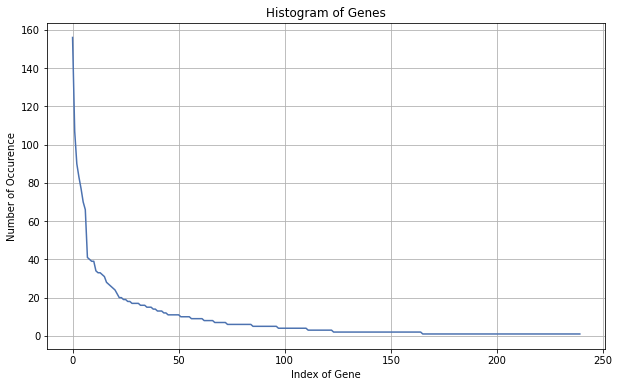

In [52]:
plt.figure(figsize=(10, 6))
plt.plot(genes_hist)
plt.title(label='Histogram of Genes')
plt.xlabel(xlabel='Index of Gene')
plt.ylabel(ylabel='Number of Occurence')
plt.grid()
plt.show()

In [53]:
genes_hist = genes_hist / genes_sum
genes_cumm_freq = np.cumsum(a=genes_hist)

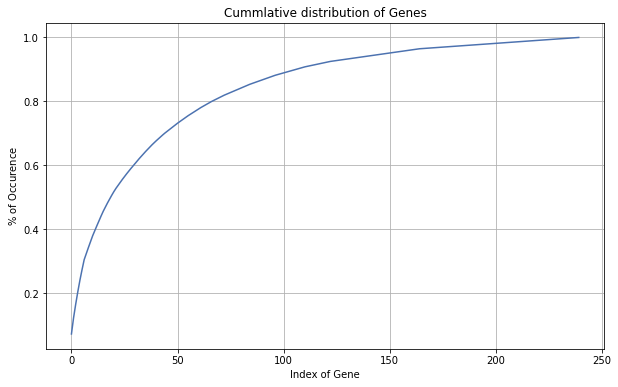

In [54]:
plt.figure(figsize=(10, 6))
plt.plot(genes_cumm_freq)
plt.title(label='Cummlative distribution of Genes')
plt.xlabel(xlabel='Index of Gene')
plt.ylabel(ylabel='$\%$ of Occurence')
plt.grid()
plt.show()

3. How to featurize the Gene feature?
    - One-Hot Encoding - better for logistice regression model
    - Response Coding - better for RandomForests model

Response Coding

In [55]:
rc = ResponseCoding(train_df=train_df, test_df=test_df, cv_df=cv_df, df_cols=['Gene'], t_col='Class')
train_gene_rc = rc.perform_response_coding(df='train', laplace=True)
cv_gene_rc = rc.perform_response_coding(df='cv', laplace=True)
test_gene_rc = rc.perform_response_coding(df='test', laplace=True)

In [56]:
print(train_gene_rc.shape)
print(cv_gene_rc.shape)
print(test_gene_rc.shape)

(2124, 9)
(532, 9)
(665, 9)


One-Hot Encoding

In [57]:
genes_vect = CountVectorizer()
train_gene_oh = genes_vect.fit_transform(raw_documents=train_df['Gene'])
cv_gene_oh = genes_vect.transform(raw_documents=cv_df['Gene'])
test_gene_oh = genes_vect.transform(raw_documents=test_df['Gene'])

In [58]:
print(train_gene_oh.shape)
print(cv_gene_oh.shape)
print(test_gene_oh.shape)

(2124, 239)
(532, 239)
(665, 239)


In [59]:
print(genes_vect.get_feature_names_out()[:5])

['abl1' 'ago2' 'akt1' 'akt2' 'akt3']


4. How good is this Gene feaure in predicting the Class label?
    - There are many ways to estimate how good a feature is, in predicting $y_i$.
    - One of the good methods is to build a proper ML model using just this feature.
    - In this case, we will build a logistic regression model using only Gene feature (one hot encoded) to predict $y_i$.

In [60]:
def build_model(X_train, X_cv, X_test, y_train, y_cv, y_test, loss, alpha_params):
    """
    This function builds the model.
    """
    log_error_list = list()
    loss_df = pd.DataFrame()
    
    for alpha_i in alpha_params:
        clf = SGDClassifier(alpha=alpha_i, loss=loss, random_state=42)
        clf.fit(X=X_train, y=y_train)
        
        sig_clf = CalibratedClassifierCV(base_estimator=clf, method='sigmoid')
        sig_clf.fit(X=X_train, y=y_train)
        
        cv_pred = sig_clf.predict_proba(X=X_cv)
        cv_l = log_loss(y_true=y_cv, y_pred=cv_pred)
        log_error_list.append(cv_l)
    
    print('Hyperparameter Tuning')
    loss_df['alpha'] = alpha_params
    loss_df['logloss'] = log_error_list
    display(loss_df)
    
    plt.figure(figsize=(10, 6))
    plt.plot(loss_df['alpha'], loss_df['logloss'], c='g')
    for i, txt in enumerate(np.round(log_error_list, 3)):
        plt.annotate(text=(alpha_params[i], txt), xy=(alpha_params[i], log_error_list[i]))
    plt.title(label='CV Error vs Alpha')
    plt.xlabel(xlabel='Alpha')
    plt.ylabel(ylabel='Error')
    plt.grid()
    plt.show()
    
    b_alpha_i = np.argmin(a=log_error_list)
    clf = SGDClassifier(alpha=alpha_params[b_alpha_i], penalty='l2', loss=loss, random_state=42)
    clf.fit(X=X_train, y=y_train)
    sig_clf = CalibratedClassifierCV(base_estimator=clf, method='sigmoid')
    sig_clf.fit(X=X_train, y=y_train)
    
    train_pred = sig_clf.predict_proba(X=X_train)
    train_loss = log_loss(y_true=y_train, y_pred=train_pred, labels=clf.classes_)
    train_cm_pred = sig_clf.predict(X=X_train)
    print("Train")
    print("Logloss (Train): {} for best alpha: {}".format(train_loss, alpha_params[b_alpha_i]))
    plot_confusion_matrix(y_true=y_train, y_pred=train_cm_pred, labels=clf.classes_)
    print(classification_report(y_true=y_train, y_pred=train_cm_pred))
    
    cv_pred = sig_clf.predict_proba(X=X_cv)
    cv_loss = log_loss(y_true=y_cv, y_pred=cv_pred, labels=clf.classes_)
    cv_cm_pred = sig_clf.predict(X=X_cv)
    print("\nCross Validation")
    print("Logloss (CV): {} for best alpha: {}".format(cv_loss, alpha_params[b_alpha_i]))
    plot_confusion_matrix(y_true=y_cv, y_pred=cv_cm_pred, labels=clf.classes_)
    print(classification_report(y_true=y_cv, y_pred=cv_cm_pred))
    
    test_pred = sig_clf.predict_proba(X=X_test)
    test_loss = log_loss(y_true=y_test, y_pred=test_pred, labels=clf.classes_)
    test_cm_pred = sig_clf.predict(X=X_test)
    print("\nTest")
    print("Logloss (Test): {} for best alpha: {}".format(test_loss, alpha_params[b_alpha_i]))
    plot_confusion_matrix(y_true=y_test, y_pred=test_cm_pred, labels=clf.classes_)
    print(classification_report(y_true=y_test, y_pred=test_cm_pred))

Hyperparameter Tuning


,alpha,logloss
0,0.00001,1.203175
1,0.00010,1.201801
2,0.00100,1.286245
3,0.01000,1.422885
4,0.10000,1.466611
5,1.00000,1.484338


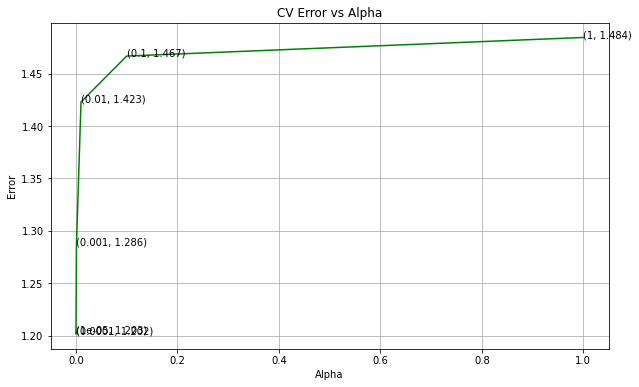

Train
Logloss (Train): 0.9762467778153312 for best alpha: 0.0001
Column sum of precision matrix: [1. 1. 1. 1. 1. 1. 1. 1. 1.]
Row sum of recall matrix:       [1. 1. 1. 1. 1. 1. 1. 1. 1.]


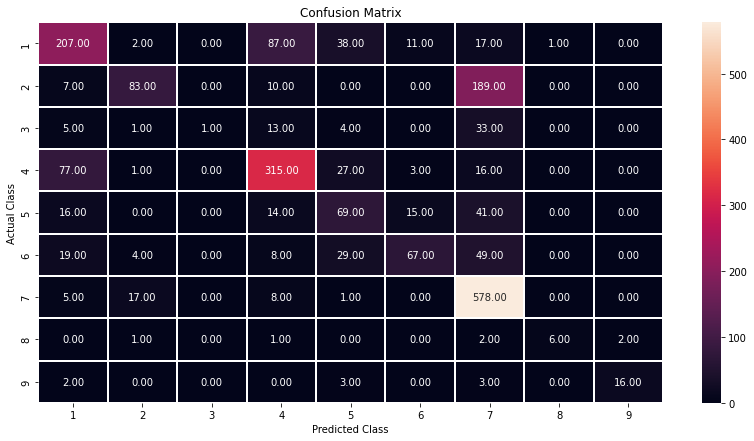

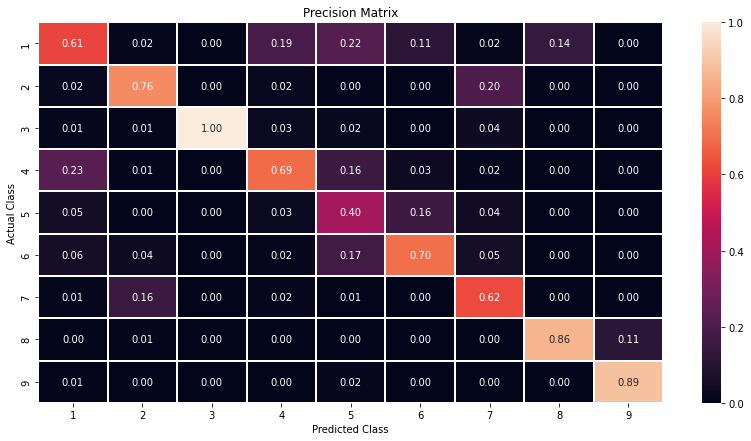

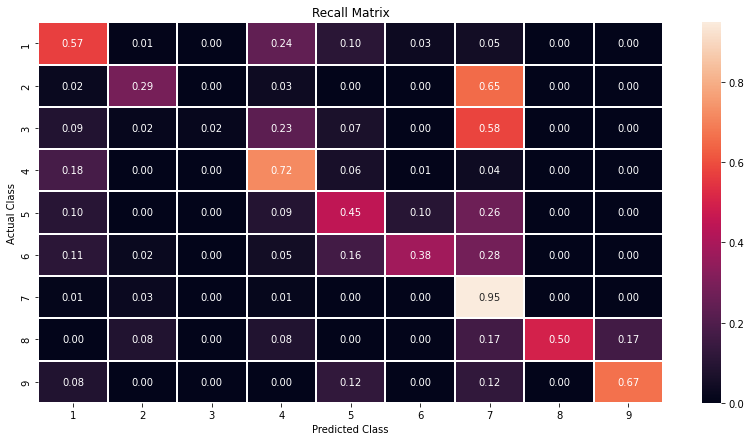

              precision    recall  f1-score   support

           1       0.61      0.57      0.59       363
           2       0.76      0.29      0.42       289
           3       1.00      0.02      0.03        57
           4       0.69      0.72      0.70       439
           5       0.40      0.45      0.42       155
           6       0.70      0.38      0.49       176
           7       0.62      0.95      0.75       609
           8       0.86      0.50      0.63        12
           9       0.89      0.67      0.76        24

    accuracy                           0.63      2124
   macro avg       0.73      0.50      0.53      2124
weighted avg       0.66      0.63      0.60      2124


Cross Validation
Logloss (CV): 1.201801422387945 for best alpha: 0.0001
Column sum of precision matrix: [ 1.  1. nan  1.  1.  1.  1.  1.  1.]
Row sum of recall matrix:       [1. 1. 1. 1. 1. 1. 1. 1. 1.]


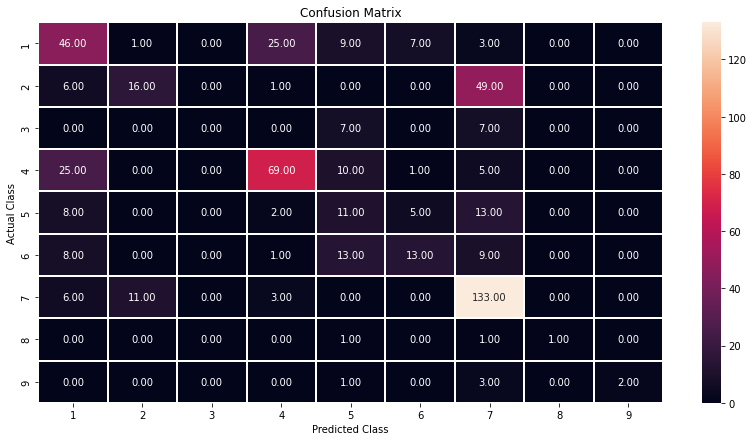

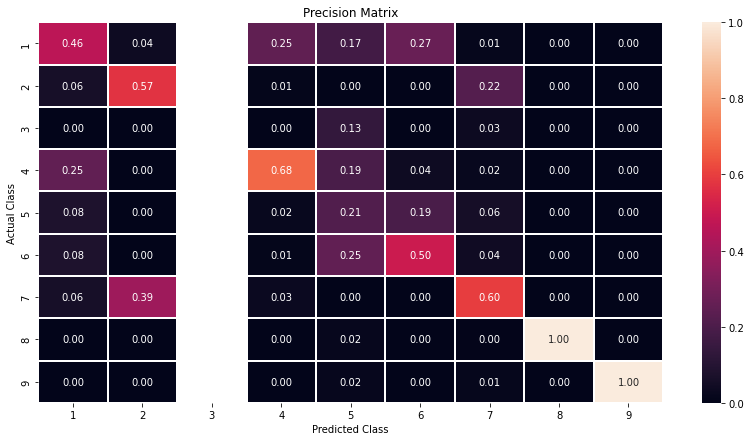

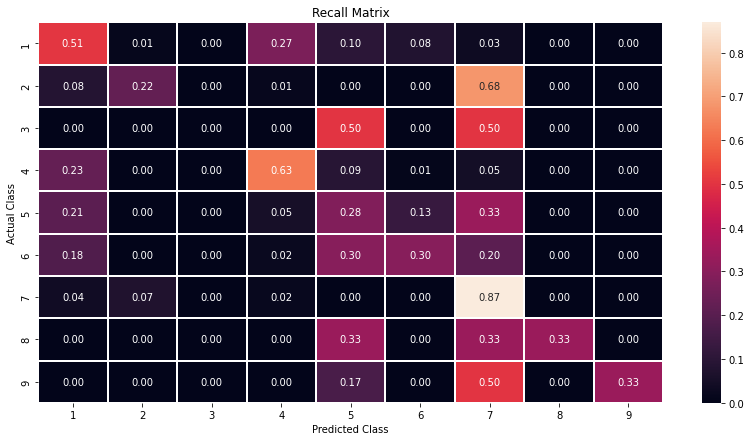

              precision    recall  f1-score   support

           1       0.46      0.51      0.48        91
           2       0.57      0.22      0.32        72
           3       0.00      0.00      0.00        14
           4       0.68      0.63      0.65       110
           5       0.21      0.28      0.24        39
           6       0.50      0.30      0.37        44
           7       0.60      0.87      0.71       153
           8       1.00      0.33      0.50         3
           9       1.00      0.33      0.50         6

    accuracy                           0.55       532
   macro avg       0.56      0.39      0.42       532
weighted avg       0.54      0.55      0.52       532


Test
Logloss (Test): 1.2044360949278967 for best alpha: 0.0001
Column sum of precision matrix: [1. 1. 1. 1. 1. 1. 1. 1. 1.]
Row sum of recall matrix:       [1. 1. 1. 1. 1. 1. 1. 1. 1.]


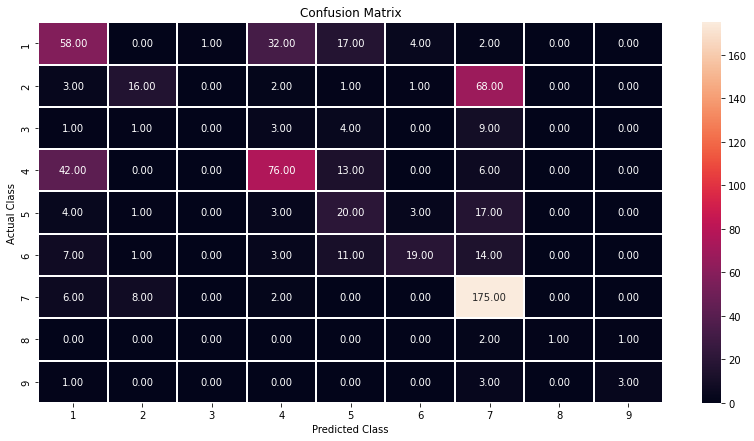

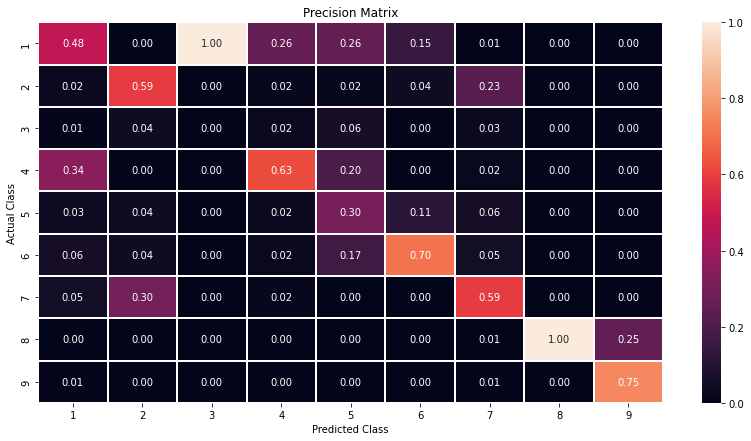

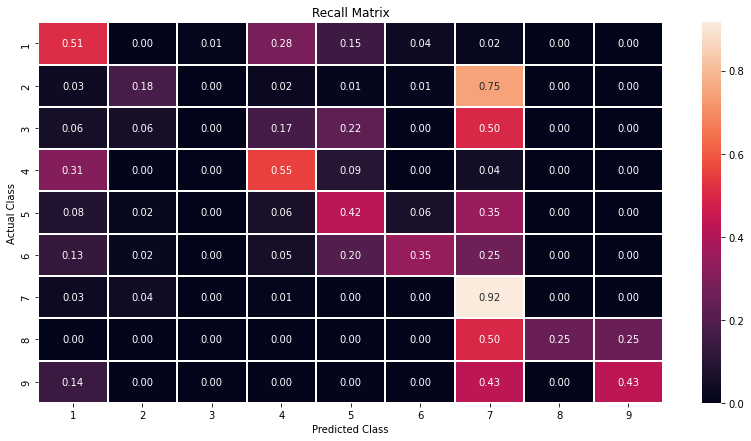

              precision    recall  f1-score   support

           1       0.48      0.51      0.49       114
           2       0.59      0.18      0.27        91
           3       0.00      0.00      0.00        18
           4       0.63      0.55      0.59       137
           5       0.30      0.42      0.35        48
           6       0.70      0.35      0.46        55
           7       0.59      0.92      0.72       191
           8       1.00      0.25      0.40         4
           9       0.75      0.43      0.55         7

    accuracy                           0.55       665
   macro avg       0.56      0.40      0.43       665
weighted avg       0.56      0.55      0.52       665



In [61]:
alpha_params = [10 ** x for x in range(-5, 1)]

build_model(X_train=train_gene_oh,
            X_cv=cv_gene_oh,
            X_test=test_gene_oh,
            y_train=y_train,
            y_cv=y_cv,
            y_test=y_test,
            alpha_params=alpha_params,
            loss='log_loss')

5. Is Gene feature stable across the data sets (Train, Test, and Validation)?
    - Yes, it is. Otherwise, the CV and Test errors would be significantly more than Train error.

In [62]:
cv_coverage = cv_df[cv_df['Gene'].isin(train_df['Gene'])]
cv_pc = round((cv_coverage.shape[0] / cv_df.shape[0]) * 100, 2)
print("CV coverage: {} / {}, percentage of coverage: {}%.".format(cv_coverage.shape[0], cv_df.shape[0], cv_pc))

test_coverage = test_df[test_df['Gene'].isin(train_df['Gene'])]
test_pc = round((test_coverage.shape[0] / test_df.shape[0]) * 100, 2)
print("Test coverage: {} / {}, percentage of coverage: {}%.".format(test_coverage.shape[0], test_df.shape[0], test_pc))

CV coverage: 515 / 532, percentage of coverage: 96.8%.
Test coverage: 649 / 665, percentage of coverage: 97.59%.
